# Sims

## Imports

In [22]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
with warnings.catch_warnings():
    warnings.simplefilter('ignore', category="SymPyDeprecationWarning")
import kwant
import kwant.continuum
import numpy as np
import tinyarray as ta
import scipy
from tqdm.notebook import tqdm
%matplotlib notebook
import matplotlib.pyplot as plt

## Definitions

In [2]:
s0 = np.identity(2)
sZ = np.array([[1.0, 0.0], [0.0, -1.0]])
sX = np.array([[0.0, 1.0], [1.0, 0.0]])
sY = np.array([[0.0, -1j], [1j, 0.0]])

sigma = {"0": s0, "X": sX, "Y": sY, "Z": sZ}

In [3]:
def hamiltonian(rashba=False, superconducting=False, micromagnets=False):
    hamiltonian_normal = (
        "A * (k_x**2 + k_y**2) * kron(sigma_z, sigma_0) +"
        "-mu_wire * kron(sigma_z, sigma_0) + "
        "0.5 * gfactor * bohr_magneton * B * kron(sigma_0, sigma_x)"
    )

    hamiltonian_rashba = "+ alpha_R * k_x * kron(sigma_z, sigma_y) + alpha_R * k_y * kron(sigma_z, sigma_x)"

    hamiltonian_superconducting = "+ delta * kron(sigma_x, sigma_0)"

    hamiltonian_micromagnets_x = "+ 0.5 * gfactor * bohr_magneton * M * sinM(x/period) * kron(sigma_0, sigma_x)"

    hamiltonian_micromagnets_y = "+ 0.5 * gfactor * bohr_magneton * M * cosM(y/period) * kron(sigma_0, sigma_y)"

    hamiltonian = (
        hamiltonian_normal
        + rashba * hamiltonian_rashba
        + superconducting * hamiltonian_superconducting
        + micromagnets * hamiltonian_micromagnets_x
        + micromagnets * hamiltonian_micromagnets_y
    )

    return hamiltonian

In [4]:
def norbitals(p):
    if p["delta"] == 0:
        return 2, False
    elif p["delta"] > 0:
        return 4, True
    else:
        raise ValueError

In [5]:
def magnetic_phase(position, p):
    counter = np.mod(position - (1 + p["barrier_length"]) * p["hopping_distance"], p["period"])
    theta = (counter / p["period"]) * 2 * np.pi
    return theta

In [6]:
def barrier_height_func(barrier_height, barrier_length, wire_length, wire_width, site):
    if barrier_region(site, wire_width, wire_length, barrier_length):
        i = site[1][1] // wire_width
        distance_from_centre = np.abs(((wire_length - 1) / 2) - i)
        dbarrier_height = barrier_height / barrier_length
        negative_distance_from_end = distance_from_centre - ((wire_length - 1) / 2)
        height = barrier_height + dbarrier_height * negative_distance_from_end
        return height
    else:
        raise IndexError("barrier_height called outside of barrier region")

In [7]:
def central_region(site, w, c_l, b_l, a):
    (x, y) = site.pos
    return b_l*a <= x < c_l*a + b_l*a and 0 <= y < w*a


def barrier_region(site, w, c_l, b_l, a):
    if type(site) == kwant.builder.Site:
        (x, y) = site.pos
    else:
        x = site // w
        y = site % w
    left_barrier = 0 <= x < b_l*a and 0 <= y < w*a
    right_barrier = c_l*a + b_l*a <= x < c_l*a + 2 * b_l*a and 0 <= y < w*a
    return left_barrier or right_barrier

In [8]:
def make_system(
#    p, onsite_wire=onsite_wire_sc, onsite_barrier=onsite_barrier, onsite_lead=onsite_lead, hopX=hopX, hopY=hopY, norbs=4
    w, c_l, b_l, central_ham, barrier_ham, a
):
    syst = kwant.Builder()

    wrapped_central_region = lambda site : central_region(site, w, c_l, b_l, a)
    wrapped_barrier_region = lambda site : barrier_region(site, w, c_l, b_l, a)

    syst.fill(barrier_ham, wrapped_barrier_region, (0, 0))
    syst.fill(central_ham, wrapped_central_region, (b_l*a, 0))
    syst.fill(barrier_ham, wrapped_barrier_region, (b_l*a + c_l*a, 0))

    def make_lead():#p=p, onsite_lead=onsite_lead, lead_hopX=lead_hopX, lead_hopY=lead_hopY, norbs=norbs):
        # Conservation law must separate the electron-hole degree of freedom -> tauZ
        # Particle-hole symmetry operator must be figured out for the Hamiltonian
        tau_z = np.kron(np.array([[1, 0], [0, -1]]), np.eye(2))
        tau_y_sig_z = np.kron(np.array([[0, -1j], [1j, 0]]), np.array([[1, 0], [0, -1]]))

        lead = kwant.Builder(
            kwant.TranslationalSymmetry((-a, 0)),
            conservation_law=-tau_z,
            particle_hole=tau_y_sig_z,
        )

        def lead_shape(site):
            (x, y) = site.pos
            return 0 <= x < 1 and 0 <= y < w*a

        lead.fill(barrier_ham, lead_shape, (0, 0))
        return lead

    # TODO Look into where the different chemical potentials are used for each lead
    l_lead = make_lead()#onsite_lead=onsite_l_lead)
    r_lead = make_lead()#onsite_lead=onsite_r_lead)
    syst.attach_lead(l_lead)
    syst.attach_lead(r_lead.reversed())

    return syst

In [9]:
def NIXIN(params):
    norbs, superconducting = norbitals(params)
    w = params['wire_width']
    c_l = params['wire_length'] - 2 * params['barrier_length']
    b_l = params['barrier_length']
    a = params['hopping_distance']
    central_ham = kwant.continuum.discretize(hamiltonian(True, superconducting, True), coords="xy", grid=a)
    barrier_ham = kwant.continuum.discretize(hamiltonian(True, False, True), coords="xy", grid=a)
    return make_system(w, c_l, b_l, central_ham, barrier_ham, a).finalized()

## Parameters

In [29]:
parameters = {
    "wire_width": 10, # [sites]
    "wire_length": 80, # [sites]
    "barrier_length": 1, # [sites]
    "stagger_ratio": 0.5, # []
    "period": 100, # [Å]
    "M": 0, # [T]
    "m_max": 2.5, # [T]
    "hopping_distance": 100, # [Å]
    "added_sinusoid": True, # []
    "B": 0, # [T]
    "b_max": 2.5, # [T]
    "bohr_magneton": 58.0E-6, # [eV/T]
    "alpha_R": 0.32, # [eV Å]
    "delta": 180.0E-6, # [eV]
    "gfactor": 10, # []
    "effective_mass": 0.019, # [m_e]
    "mu_wire": 0.0E-3, # [eV]
    "mu_barrier": 18.0E-3, # [eV]
    "mu_lead": 0.0E-3, # [eV]
    "barrier_height": 0.02 # [eV]
}

parameters["A"] = 3.82 / parameters["effective_mass"]
parameters["sinM"] = np.sin
parameters["cosM"] = np.cos

## Simulation

In [30]:
B_values=np.linspace(0, 2.5, 51)
tolerance=1e-5
syst = NIXIN(parameters)
energies = []
critB = 0

First I need to find the optimal chemical potential to caluclate this at. This is the chemical potential which offsets the particle in a box solution (remember they add, which is why the short axis is dominant).

In [31]:
temp_p = parameters.copy()
temp_p["B"]=0
temp_p["M"] = 0
temp_p["delta"]=0
temp_p["mu_wire"]=0
mu_syst=NIXIN(temp_p)
Ht = mu_syst.hamiltonian_submatrix(sparse=True, params=temp_p)
Ht = Ht.tocsc()
eigs = scipy.sparse.linalg.eigsh(Ht, k=2, sigma=0)
eigs = np.sort(eigs[0])
new_mu = (eigs[1]-eigs[0])/2

In [32]:
new_mu

0.0014208739284363309

In [33]:
newparams = parameters.copy()
newparams["mu_wire"] = new_mu + newparams["mu_wire"]

for b in tqdm(B_values, desc="Spec",):
    newparams["B"] = b
    H = syst.hamiltonian_submatrix(sparse=True, params=newparams)
    H = H.tocsc()
    # k is the number of eigenvalues, and find them near sigma.
    eigs = scipy.sparse.linalg.eigsh(H, k=20, sigma=0)
    eigs = np.sort(eigs[0])
    energies.append(eigs)

Spec:   0%|          | 0/51 [00:00<?, ?it/s]

<IPython.core.display.Javascript object>


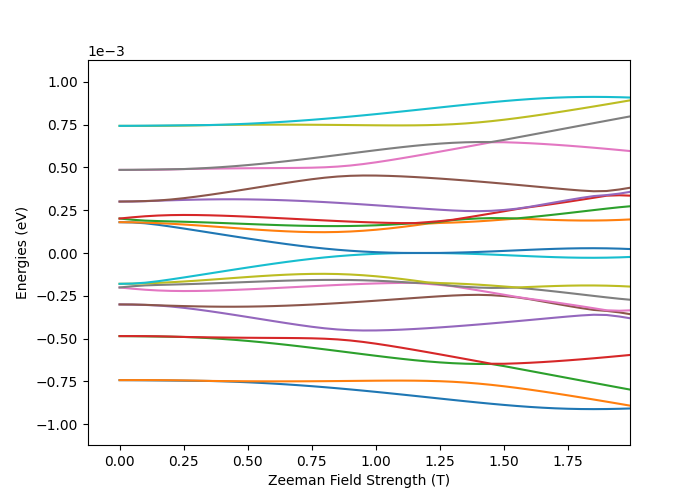

[]

In [34]:
fig = plt.figure()
plt.rcParams["figure.figsize"] = (7, 5)
ax = fig.gca()
ax.plot(B_values, energies)
ax.set_xlabel("Zeeman Field Strength (T)")
ax.set_ylabel("Energies (eV)")
plt.ticklabel_format(axis="both", style="sci", scilimits=(0, 0))
plt.plot()

## Model figure

In [16]:
w = parameters['wire_width']
c_l = parameters['wire_length'] - 2 * parameters['barrier_length']
b_l = parameters['barrier_length']
a = parameters['hopping_distance']

In [17]:
a

100

<IPython.core.display.Javascript object>


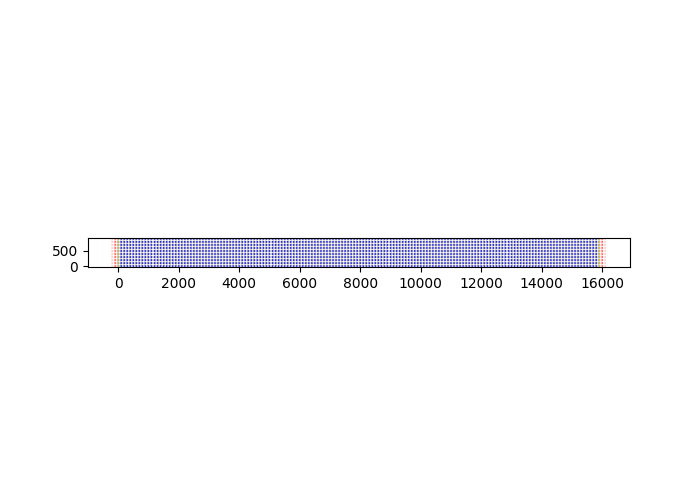

In [20]:
plot = kwant.plot(syst, show=True, site_color=lambda s: "y" if barrier_region(s, w, c_l, b_l, 1) else "b")